# DATA SCIENTIST NANODEGREE - SPARKIFY CAPSTONE PROJECT
## Part 1 - Analyses

<img src="images/udacity-logo.png" alt="udacity logo" width="800"/>

## Introduction

Imagine a fictitious company Sparkify. A music streaming company similar to the likes of Spotify and Pandora. Millions of users listen to their favorite songs and discover new music on Sparkify. 
<img src='images/sparkify.png' alt='sparkify logo'/>
Sparkify collects data of all user interactions. The interactions include playing a song, liking a song, disliking a song, adding a friend, etc. This data is a treasure cove to understand user behavior which can help the company improve the product.

Like all subscription based services, the users of the services are either Paid or Free users. Paid users pay a monthly fee whereas Free users are served ads to drive revenue. Such a business model requires the company to do all they can to retain users on the platform. As long as the user continues to use the service, the company makes revenue either from subscription fees or from advertisements. 

So when a user stops using the service altogether, it is said that the user has churned. A service like Sparkify must keep a close eye on a metric that measures this churn and do everything in it's power to keep this metric at a reasonable rate.

In this project, we will try to use the user event logs collected by Sparkify to identify behaviors of users to continue to use the service as opposed to the ones that churned.

## About the dataset and tools used

As already mentioned, the dataset is a collection of events that was generated by users of the fictitious Sparkify. The dataset used here is a subset (256MB) of the full dataset (12GB).

While the small subset used here can fit in the memory of the local machine, the full dataset will cause issues due to its large size. This is the exact problem that distributed computing resolves. As the name Sparkify already suggests, this project utilizes Apache Spark, more specifically the PySpark python API. This way the code used on the subset can easily be used to process the full dataset on a full fledged cluster without any changes.

This notebook heavily relies on the utility_functions module. This module contains all functions which help in plotting, creating new columns etc. This way, the module can be readily used for any scripts. For instance, a script can be created to create the feature matrix from the given event log data at periodic intervals and stored in a database that ML engineers and Data Scientist can utilize of ML modelling. 

## Structure of this notebook

1. Import and inspect the dataset for missing values and handling them
2. Exploratory data analysis
3. Defining churn and identifying churned users
4. Create and compare various features of churned and non-churned users
5. Using the features, prepare a dataset that can be fed to a machine learning model
6. Conclusion of Part 1

## Import and inspect the dataset for missing values and handling them

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, to_date, from_unixtime, lead
from pyspark.sql.types import IntegerType, StringType, DateType
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import round as Fround
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
import datetime
import warnings
from utility_functions import *

warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', None)
pd.set_option("display.max_rows", None)

In [2]:
# File location and type
file_location = "medium-sparkify-event-data.json"
file_type = "json"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# read the json data file
df_data_1 = import_data_into_dataframe(file_location, file_type, infer_schema, first_row_is_header, delimiter)

df_data_1.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [181]:
print(f"There are {len(df_data_1.columns)} columns and {df_data_1.count()} rows. The schema of the dataset is as shown below:")
df_data_1.printSchema()

There are 18 columns and 543705 rows. The schema of the dataset is as shown below:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



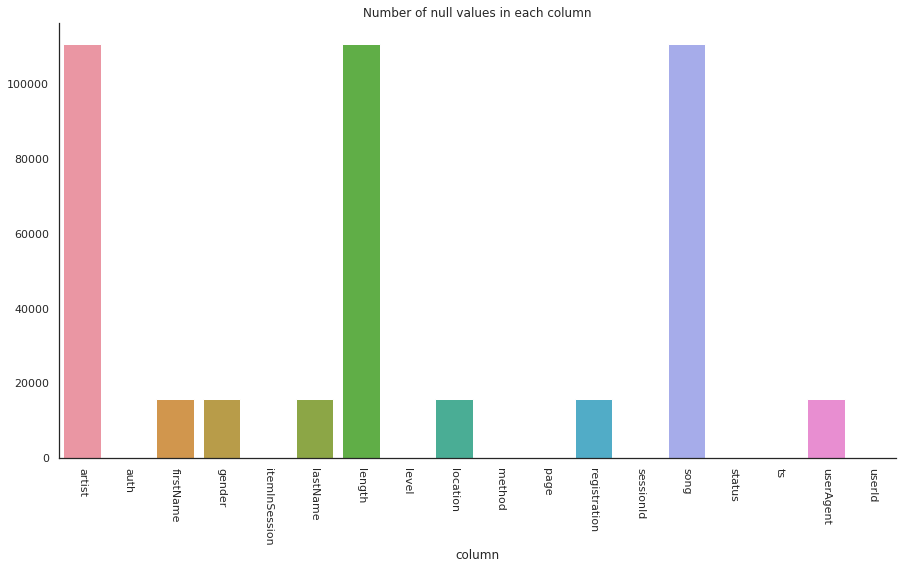

In [3]:
# look for null values
null_counts = count_null_values_for_each_column(df_data_1)
plot_bar_graph(list(null_counts.keys()), list(null_counts.values()), "Number of null values in each column", "column")

From the bar graph, it can be seen that some columns have identical number of missing values. This probably means that depending on the type of event, only certain number of fields are filled. Let's confirm this.

In [183]:
print("The pages for which artist is null")
set(df_data_1.filter("artist is null").select("page").distinct().collect())

The pages for which artist is null


{Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Login'),
 Row(page='Logout'),
 Row(page='Register'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Registration'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')}

In [184]:
print("The pages for which artist is not null")
set(df_data_1.select("page").distinct().collect()) - set(df_data_1.filter("artist is null").select("page").distinct().collect())

The pages for which artist is not null


{Row(page='NextSong')}

Here, it can be seen that the artist column is null for all events except for the "NextSong" event.

In [185]:
print("The pages for which firstName is not null")
set(df_data_1.select('page').distinct().collect()) - set(df_data_1.filter("firstName is null").select("page").distinct().collect())

The pages for which firstName is not null


{Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')}

In [186]:
print("The pages for which firstName is null")
set(df_data_1.filter("firstName is null").select("page").distinct().collect())

The pages for which firstName is null


{Row(page='About'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Submit Registration')}

Here, the first name is null for events such as visiting the "About", "Help", "Login" page.

We can conclude that fields artist, length and song are dependent on each other, in the same way as the fields firstName, lastName, gender, location, registration and userAgent are dependent on each other. 

The fields artist, length and song are populated only for the page NextSong.

The firstName, lastName, gender, location, registration and userAgent are present for all actions that require the user to be logged in such as listening to a song, adding friends, changing settings etc but are null for pages that dont require the user to be logged in such as the Home, Help, Register pages. 

So far we have looked into the overall dataset for any nulls. Now let's look at the different datatypes and look for erroneous values.

In [187]:
# the different data types present in the dataset
count_column_types(df_data_1)

,type,count,names
0,bigint,5,status | itemInSession | registration | sessionId | ts
1,double,1,length
2,string,12,auth | location | lastName | page | firstName | userId | level | method | gender | song | userAgent | artist


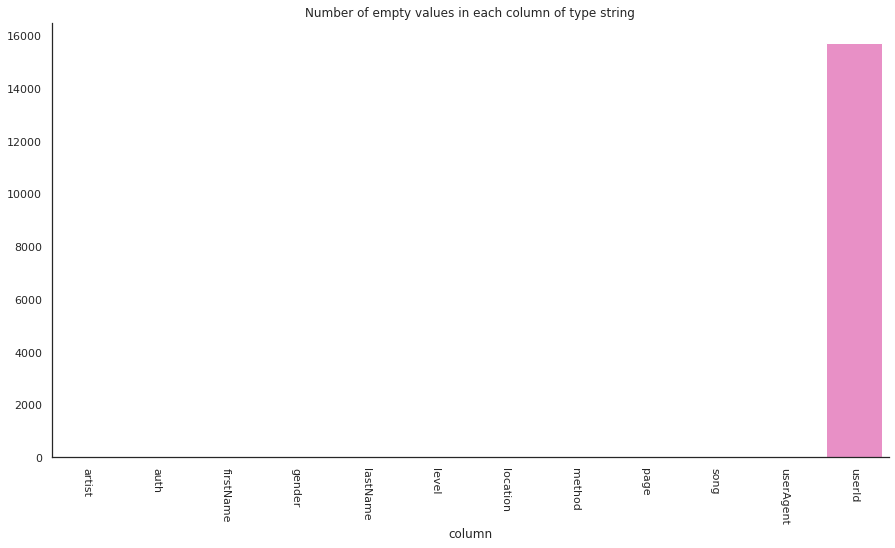

In [188]:
# looking for empty strings in columns of type string
empty_string_values = count_empty_strings_for_each_string_column(df_data_1)
plot_bar_graph(list(empty_string_values.keys()), list(empty_string_values.values()), "Number of empty values in each column of type string", "column")

In [189]:
df_data_1.where("userId is not null").where(pyspark_func_to_trim_strings()(df_data_1['userId']) == '').show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          186|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352148000|     null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352151000|     null|      |
|  null|Logged Out|     null|  null|          188|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352168000|     null|      |
|  null|Logged Out|     null|  nul

After observing the bar graph and looking into some of the rows where userId is empty, we can conclude that userId is an empty string for events where the user is not logged in. 

In [190]:
# now let's look into numeric columns
df_data_1.describe(get_columns_of_type(df_data_1, 'bigint')).show()

+-------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|        registration|         sessionId|            status|                  ts|
+-------+------------------+--------------------+------------------+------------------+--------------------+
|  count|            543705|              528005|            543705|            543705|              543705|
|   mean|107.30629109535502|1.535523414862806...|2040.8143533717732|210.01829116892432|1.540964541209808E12|
| stddev|116.72350849187941|3.0787254929942865E9|1434.3389310782754| 31.47191902156764|1.4820571448945475E9|
|    min|                 0|       1509854193000|                 1|               200|       1538352011000|
|    max|              1005|       1543073874000|              4808|               404|       1543622466000|
+-------+------------------+--------------------+------------------+------------------+--------------------+



In [191]:
df_data_1.describe(get_columns_of_type(df_data_1, 'double')).show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            432877|
|   mean|248.66459278007807|
| stddev| 98.41266955052018|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



The status column contains the http request codes, I do not think it could be of much use to us.

The length column is the duration of the song, again this is of little use.

No other funny values.

Now, before we go further with EDA, let's remove all rows with an empty user id. The aim is to identify users who could churn, hence rows not related to an user is not of interest.

In [7]:
clean_data = clean_dataset(df_data_1)
clean_data.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [8]:
clean_data.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## Exploratory data analysis

In [194]:
clean_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [196]:
# get frequency counts of the categoric fields
print('-'*50)
top_users = get_summary_of_category_column('userId', clean_data, print_result=True)
print('-'*50)
top_artists = get_summary_of_category_column('artist', clean_data, print_result=True)
print('-'*50)
auth_counts = get_summary_of_category_column('auth', clean_data, print_result=True)
print('-'*50)
page_counts = get_summary_of_category_column('page', clean_data, print_result=True)
print('-'*50)
location_counts = get_summary_of_category_column('location', clean_data, print_result=True)
print('-'*50)
registration_counts = get_summary_of_category_column('registration', clean_data, print_result=True)
print('-'*50)
song_counts = get_summary_of_category_column('song', clean_data, print_result=True)
print('-'*50)
userAgent_counts = get_summary_of_category_column('userAgent', clean_data, print_result=True)
print('-'*50)
gender_activity = get_summary_of_category_column("gender", clean_data, print_result=True)
print('-'*50)
level_activity = get_summary_of_category_column("level", clean_data, print_result=True)
print('-'*50)
level_counts = get_counts_for_unique_users("level", clean_data, print_result=True)
print('-'*50)
gender_counts = get_counts_for_unique_users("gender", clean_data, print_result=True)
print('-'*50)

--------------------------------------------------
There are 448 unique userId/s and the most frequent are: 
   userId  count
0      92   9767
1     140   7448
2  300049   7309
3     101   6842
4  300035   6810
5     195   6184
6     230   6019
7     163   5965
8     250   5678
9      18   5511
--------------------------------------------------
There are 21247 unique artist/s and the most frequent are: 
                   artist  count
0           Kings Of Leon   3497
1                Coldplay   3439
2  Florence + The Machine   2314
3                    Muse   2194
4           Dwight Yoakam   2187
5          The Black Keys   2160
6                BjÃÂ¶rk   2150
7           Justin Bieber   2096
8            Jack Johnson   2049
9               Radiohead   1694
--------------------------------------------------
There are 2 unique auth/s and the most frequent are: 
        auth   count
0  Logged In  527906
1  Cancelled      99
--------------------------------------------------
There are 1

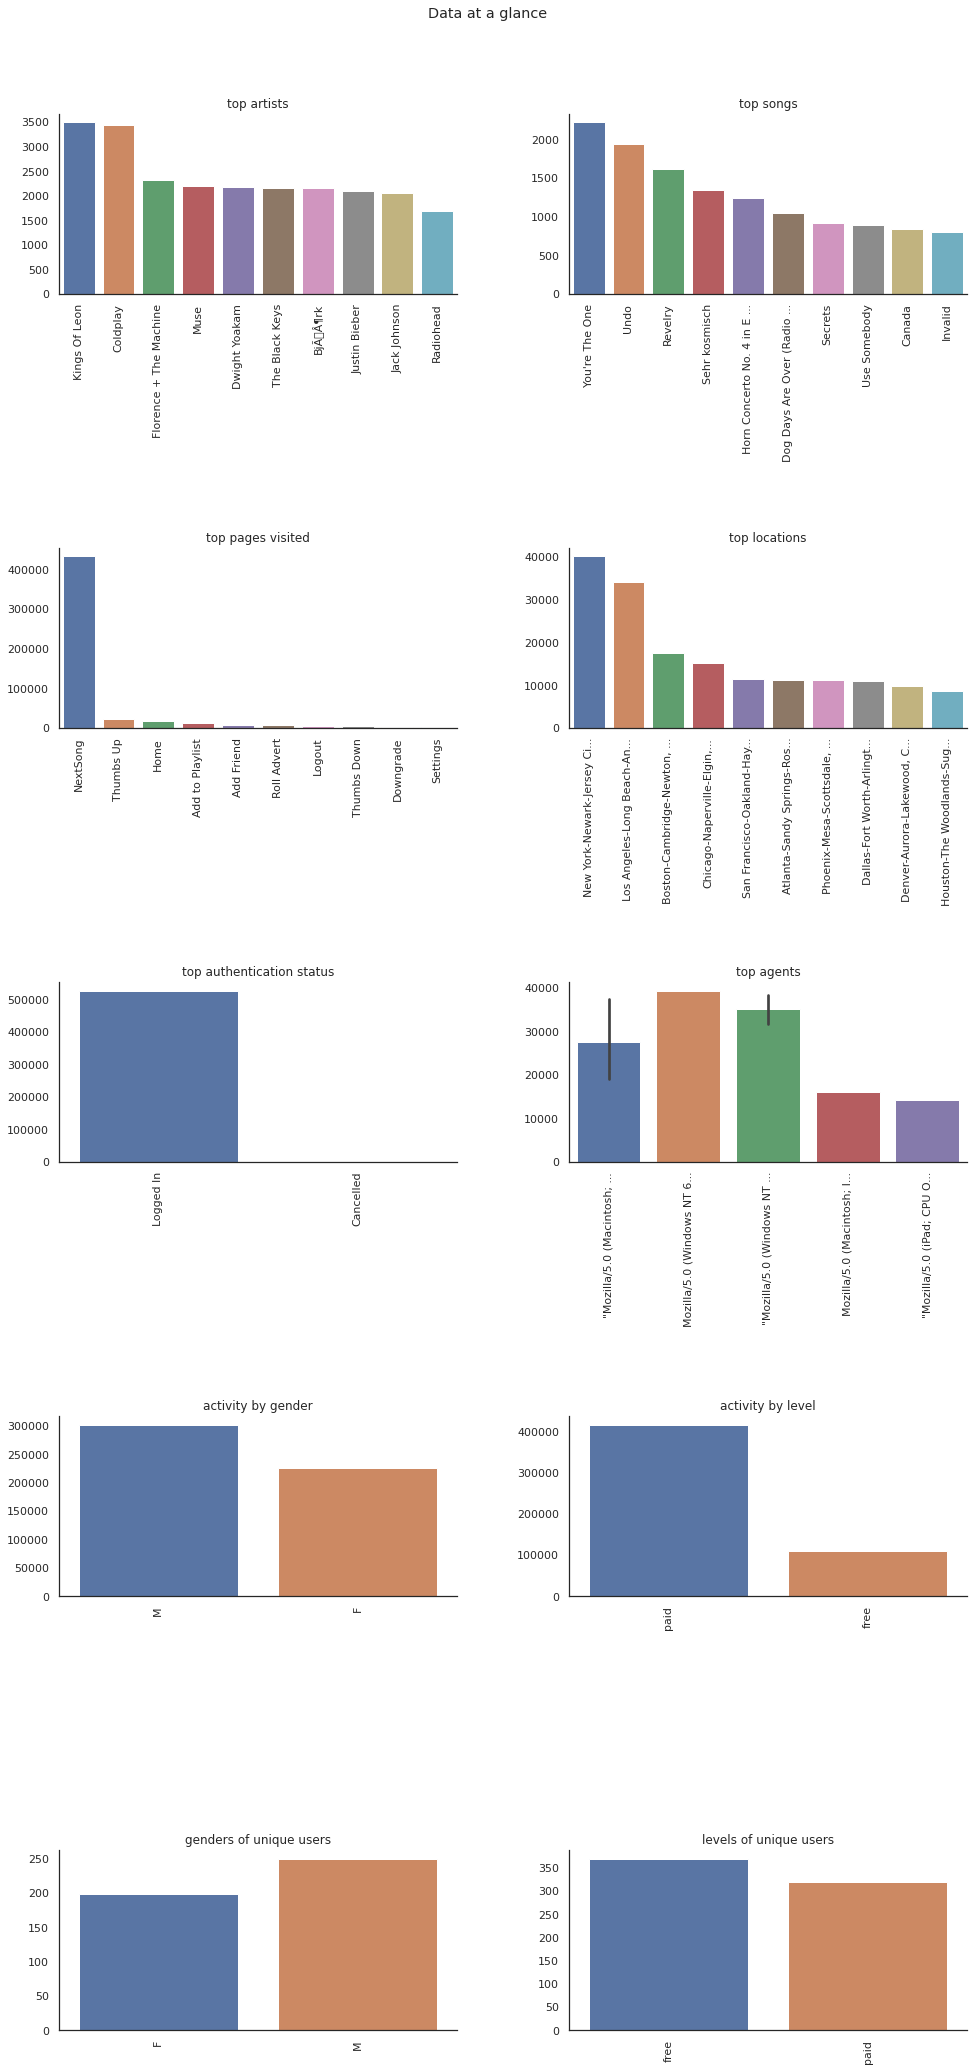

In [197]:
# visualizing the same
count_df_to_plot = [top_artists, song_counts, page_counts, location_counts, auth_counts, userAgent_counts, gender_activity, level_activity, gender_counts, level_counts]
titles = ['top artists', 'top songs', 'top pages visited', 'top locations', 'top authentication status', 'top agents', 'activity by gender', 'activity by level', "genders of unique users", "levels of unique users"]

create_summary_plots(count_df_to_plot, titles, 5, 2, "Data at a glance");

<b>Observations from the above plots:</b>
- The most frequented action is "NextSong", this makes sense as users use the service to listen to music
- New York,Newark,Jersey City are the source of most traffic to this service
- For some strange reason, the user agent is mostly always Mozilla
- Most events occur with the user logged in
- Most activity is from males
- There is four times more activity from paid users then free users
- There are more males (250) than females (198) in this dataset - Total of 448 users
- There are more free (370) accounts than paid (321), adding upto 691. This number is higher than the number of users because user can ugrade or downgrade. And as a result, if a user has changed levels, then the same user would be counted twice in this bar chart.

Let's use the timestamp for some timeseries analysis

In [198]:
datetime.datetime.fromtimestamp(1538352011000/1000.0).day

1

In [10]:
convert_to_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0))
convert_to_datetime_string = udf(lambda x: str(x))
convert_to_hour = udf(lambda x: x.hour)
convert_to_year = udf(lambda x: x.year)
convert_to_month = udf(lambda x: x.month)
convert_to_day = udf(lambda x: x.day)

In [11]:
# Add time details

clean_data = clean_data.withColumn("timestamp", convert_to_datetime("ts")).withColumn("dt_string", convert_to_datetime_string("timestamp")).withColumn("year", convert_to_year("timestamp")).withColumn("month", convert_to_month("timestamp"))\
.withColumn("hour", convert_to_hour("timestamp")).withColumn("day", convert_to_day("timestamp"))
clean_data.select(['ts', 'timestamp', 'dt_string', 'year', 'month', 'hour', 'day']).show(20)

+-------------+--------------------+-------------------+----+-----+----+---+
|           ts|           timestamp|          dt_string|year|month|hour|day|
+-------------+--------------------+-------------------+----+-----+----+---+
|1538352011000|java.util.Gregori...|2018-10-01 00:00:11|2018|   10|   0|  1|
|1538352025000|java.util.Gregori...|2018-10-01 00:00:25|2018|   10|   0|  1|
|1538352118000|java.util.Gregori...|2018-10-01 00:01:58|2018|   10|   0|  1|
|1538352119000|java.util.Gregori...|2018-10-01 00:01:59|2018|   10|   0|  1|
|1538352124000|java.util.Gregori...|2018-10-01 00:02:04|2018|   10|   0|  1|
|1538352125000|java.util.Gregori...|2018-10-01 00:02:05|2018|   10|   0|  1|
|1538352176000|java.util.Gregori...|2018-10-01 00:02:56|2018|   10|   0|  1|
|1538352215000|java.util.Gregori...|2018-10-01 00:03:35|2018|   10|   0|  1|
|1538352241000|java.util.Gregori...|2018-10-01 00:04:01|2018|   10|   0|  1|
|1538352259000|java.util.Gregori...|2018-10-01 00:04:19|2018|   10|   0|  1|

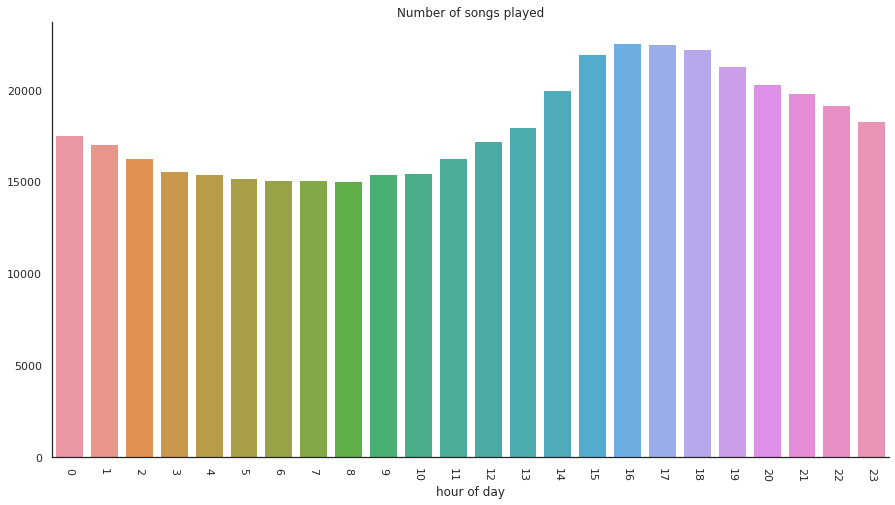

In [201]:
# total number of songs played during the different hours of the day
song_per_hour_of_day = clean_data.filter(clean_data.page == "NextSong").groupBy("hour").count().toPandas()
song_per_hour_of_day.hour = pd.to_numeric(song_per_hour_of_day.hour)
plot_bar_graph(song_per_hour_of_day["hour"], song_per_hour_of_day["count"], "Number of songs played", "hour of day")

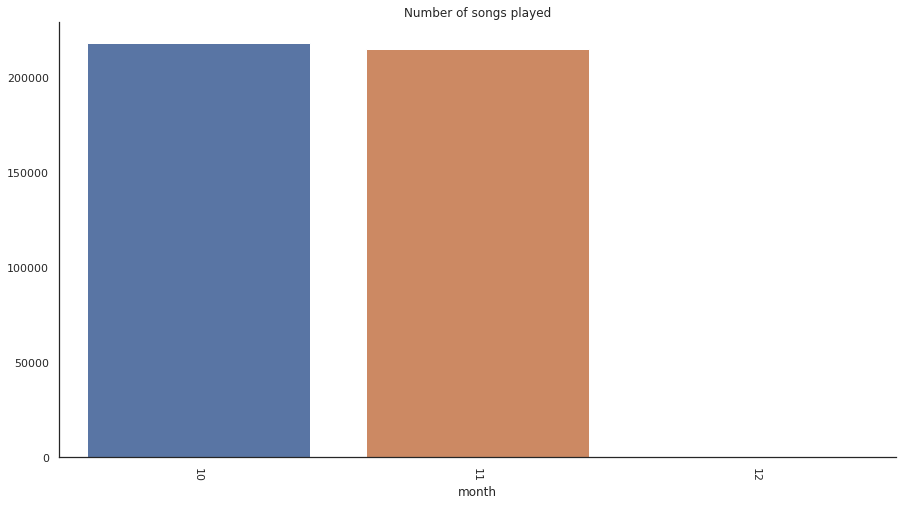

In [203]:
# total songs played during the different months
song_per_month = clean_data.filter(clean_data.page == "NextSong").groupBy("month").count().toPandas()
song_per_month.month = pd.to_numeric(song_per_month.month)
plot_bar_graph(song_per_month["month"], song_per_month["count"], "Number of songs played", "month")

In [204]:
clean_data.select("year","month").distinct().show()

+----+-----+
|year|month|
+----+-----+
|2018|   10|
|2018|   12|
|2018|   11|
+----+-----+



<b>The data we have in hand is of the last 3 months of 2018.</b>

In [205]:
total_records = clean_data.count()
day_wise_counts = clean_data.groupBy("year","month",'day').count().toPandas()
for colm in day_wise_counts.columns:
  day_wise_counts[colm] = pd.to_numeric(day_wise_counts[colm])
day_wise_counts = day_wise_counts.sort_values(by=['year','month','day'])
day_wise_counts['total%'] = day_wise_counts['count'].cumsum() / total_records * 100
day_wise_counts

,year,month,day,count,total%
22,2018,10,1,6977,1.321389
12,2018,10,2,8821,2.992017
6,2018,10,3,9888,4.864727
61,2018,10,4,9893,6.738383
55,2018,10,5,10353,8.699160
59,2018,10,6,5956,9.827180
57,2018,10,7,2380,10.277933
28,2018,10,8,9743,12.123181
20,2018,10,9,10065,14.029413
4,2018,10,10,10611,16.039053


## Defining churn and identifying churned users

Given the nature of subscription based business models, there are two type of churners - users who downgrade from a Paid user to a Free user and users who stop users the service altogether by way to deleting their registered account.

The event 'Downgrade' is logged when user changes their level from 'Paid' to 'Free' and the event 'Cancellation Confirmation' is logged when the user deletes their account.

While both the types of churners affect the amount of business the service does, the users who delete their account is more detrimental. This is because the service continues to make revenue even though the user is a Free user through advertisements. Whereas once a user deletes their account, the service makes stops making revenue from that user. 

Hence, we will be identifying these users who delete their accounts are churners. 

In [12]:
clean_data.unpersist()
# add a column to flag the 'Cancellation Confirmation' event
clean_data = add_column_to_flag_cancellation_event(clean_data)

In [255]:
clean_data.select("userId", "user_cancelled").show(20)

+------+--------------+
|userId|user_cancelled|
+------+--------------+
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
|    10|             0|
+------+--------------+
only showing top 20 rows



In [208]:
clean_data.groupBy("user_cancelled").count().show()

+--------------+------+
|user_cancelled| count|
+--------------+------+
|             0|527906|
|             1|    99|
+--------------+------+



There are 99 cancellation events

In [13]:
# add a column to mark all rows as either belonging to a churned user or not
clean_data = add_column_to_mark_rows_for_churned_users(clean_data)

In [257]:
clean_data.persist()
clean_data.select("userId", "sessionId", "dt_string", "page", "churned").show()

+------+---------+-------------------+---------+-------+
|userId|sessionId|          dt_string|     page|churned|
+------+---------+-------------------+---------+-------+
|    10|        9|2018-10-08 02:20:20| NextSong|    1.0|
|    10|        9|2018-10-08 02:20:43|     Home|    1.0|
|    10|        9|2018-10-08 02:24:45| NextSong|    1.0|
|    10|        9|2018-10-08 02:28:44| NextSong|    1.0|
|    10|        9|2018-10-08 02:31:21| NextSong|    1.0|
|    10|        9|2018-10-08 02:34:33| NextSong|    1.0|
|    10|        9|2018-10-08 02:38:01| NextSong|    1.0|
|    10|        9|2018-10-08 02:45:21| NextSong|    1.0|
|    10|        9|2018-10-08 02:48:36| NextSong|    1.0|
|    10|        9|2018-10-08 02:52:07| NextSong|    1.0|
|    10|        9|2018-10-08 02:55:29| NextSong|    1.0|
|    10|        9|2018-10-08 02:57:29| NextSong|    1.0|
|    10|        9|2018-10-08 03:08:24| NextSong|    1.0|
|    10|        9|2018-10-08 03:12:20| NextSong|    1.0|
|    10|        9|2018-10-08 03

Now that we have marked the rows as belong to a churned or nonchurned user, we will now split the data into train and test before we go ahead with feature engineering.

In [258]:
users_marked = mark_users_as_churners(clean_data)
users_marked.groupBy("churned").count().show()

+-------+-----+
|churned|count|
+-------+-----+
|    0.0|  349|
|    1.0|   99|
+-------+-----+



<b>There are 99 users who churned. </b>

Now that we have identifies churned users and marked their rows, it is good time to split the dataset into train and test before we create and compare features among the two groups.

We will split the dataset into train and test with a stratified 80-20 split.

In [14]:
train_data, train_users, test_data, test_users = split_into_train_test_80_20(clean_data)
train_info = train_users.groupBy("churned").count().toPandas()
test_info = test_users.groupBy("churned").count().toPandas()

In [213]:
print(f"There are {len(train_data.columns)} columns and {train_data.count()} rows in the train data set")
print(f"The train data set has information about {train_data.select('userId').distinct().count()} users")
print(f"Out of which {train_info[train_info.churned == 0]['count'][0]} are non churners and {train_info[train_info.churned == 1]['count'][1]} are churners")
print(f"There are {len(test_data.columns)} columns and {test_data.count()} rows in the test data set")
print(f"The test data set has information about {test_data.select('userId').distinct().count()} users")
print(f"Out of which {test_info[test_info.churned == 0]['count'][0]} are non churners and {test_info[test_info.churned == 1]['count'][1]} are churners")

There are 26 columns and 414579 rows in the train data set
The train data set has information about 363 users
Out of which 285 are non churners and 78 are churners
There are 26 columns and 113426 rows in the test data set
The test data set has information about 85 users
Out of which 64 are non churners and 21 are churners


In [15]:
clean_data.unpersist()
train_data.persist()
train_users.persist()
test_data.persist()
test_users.persist()

DataFrame[userId: string, churned: double]

## Create and compare various features of churned and non-churned users

Feature Engineering: Based on the event logs, we will engineer the following features
- Average Number of songs per session
- Average number of adverts served per session
- Average number of visits to the home page per session
- Average number of visits to the about page per session
- Average number of visits to the help page per session
- Average number of visits to the settings page per session
- Average number of times settings changed per session
- Average number of thumbs up per session
- Average number of thumbs down per session
- Average number of add to playlists per session
- Average number of AddFriends per session
- Average number of Errors faced per session
- Average number of visits to the upgrade page
- Average number of visits to the downgrade page
- Average number of different artists listened per session
- Number of different levels the user switched
- Number of submit upgrades
- Number of submit downgrades

<b>Average number of songs per session : NextSong</b>

<b>The medians are very close to each other but non-churners listen to slighlty more number of songs per session</b>

+------+----------------------------+
|userId|avg_num_of_songs_per_session|
+------+----------------------------+
|100010|                        48.0|
|   296|                        22.4|
|   125|                       20.67|
|   124|                      114.13|
|     7|                        30.8|
|200037|                       17.43|
|   169|                        14.0|
|   205|                       209.6|
|   272|                        48.5|
|   232|                       81.57|
+------+----------------------------+
only showing top 10 rows



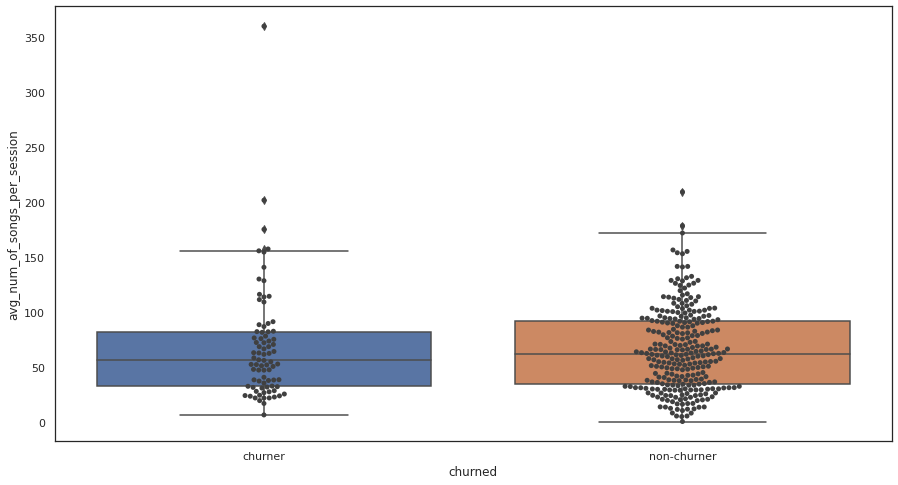

In [220]:
avg_num_of_songs_per_session = comparison_summary("NextSong", "avg_num_of_songs_per_session", train_data, train_users, True, "songs per session")

<b>Average number of adverts served per session : Roll Advert</b>

<b>Again, no major differences but churners are shown  number of adverts per session</b>

+------+------------------------------+
|userId|avg_num_of_adverts_per_session|
+------+------------------------------+
|100010|                          11.0|
|   296|                           4.5|
|   125|                           3.0|
|   124|                           1.0|
|     7|                          3.18|
|200037|                           1.8|
|   169|                          2.17|
|   272|                           6.0|
|   232|                          3.17|
|   234|                           3.0|
+------+------------------------------+
only showing top 10 rows



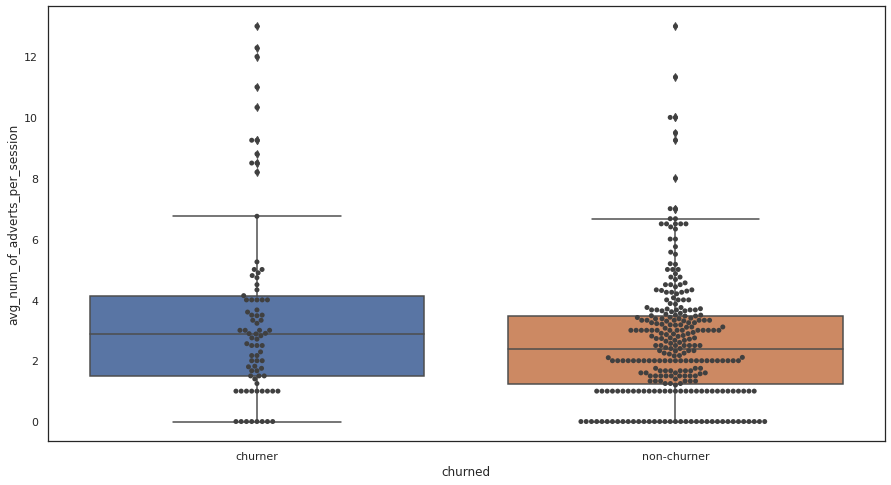

In [222]:
avg_num_of_adverts_per_session = comparison_summary("Roll Advert", "avg_num_of_adverts_per_session", train_data, train_users, True, "adverts per session")

<b>Average number of visits to the home page per session : Home</b>

<b>Churners and Non churners visit the Home page nearly the same number of times per sesssion</b>

+------+-------------------------------------+
|userId|avg_num_of_visits_to_home_per_session|
+------+-------------------------------------+
|100010|                                  1.5|
|   296|                                 2.33|
|   125|                                  1.0|
|   124|                                 4.67|
|     7|                                  2.4|
|200037|                                  2.0|
|   169|                                  1.5|
|   205|                                  8.6|
|   272|                                  2.5|
|   232|                                  5.0|
+------+-------------------------------------+
only showing top 10 rows



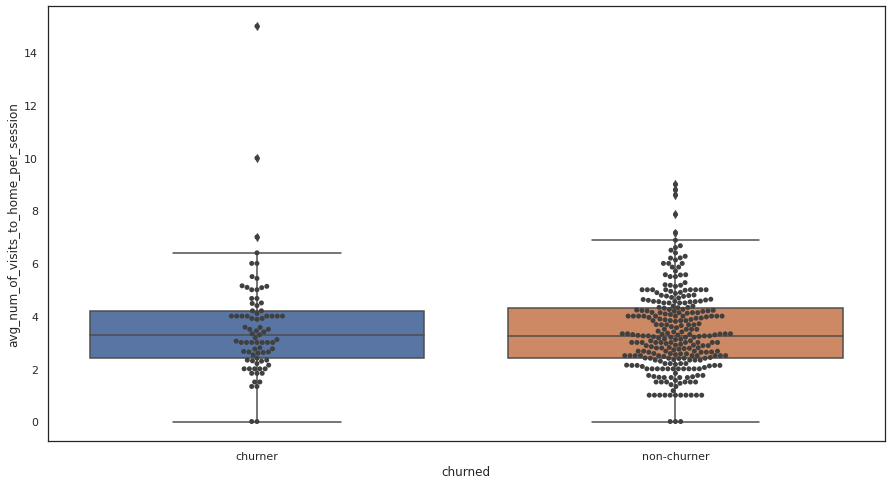

In [223]:
avg_num_of_visits_to_the_home_page_per_session = comparison_summary("Home", "avg_num_of_visits_to_home_per_session", train_data, train_users, True, "number of visits to the home page")

<b>Average number of visits to the about page per session : About</b>

<b>Both visit the About page with same frequency, however it is more varied among non-churners </b>

+------+------------------------------------------------------+
|userId|average_number_of_visits_to_the_about_page_per_session|
+------+------------------------------------------------------+
|   124|                                                   1.5|
|     7|                                                   1.0|
|200037|                                                   1.0|
|   205|                                                   1.5|
|   232|                                                   1.2|
|   234|                                                   1.0|
|   282|                                                   1.2|
|    54|                                                   2.0|
|   132|                                                   1.0|
|   200|                                                   1.0|
+------+------------------------------------------------------+
only showing top 10 rows



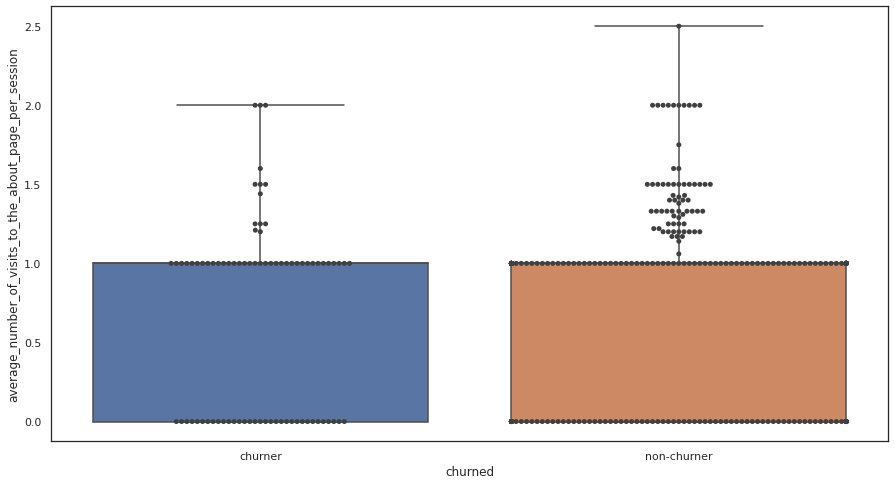

In [224]:
avg_num_of_visits_to_the_about_page_per_session = comparison_summary("About", "average_number_of_visits_to_the_about_page_per_session", train_data, train_users, True, "number of visits to the About page per session")

<b>Average number of visits to the help page per session : Help</b>

<b>The churners visit the help page slightly more frequently per session </b>

+------+-----------------------------------------------------+
|userId|average_number_of_visits_to_the_help_page_per_session|
+------+-----------------------------------------------------+
|   296|                                                  1.0|
|   125|                                                  2.0|
|   124|                                                  2.0|
|     7|                                                  1.0|
|   205|                                                 2.75|
|   232|                                                  2.1|
|   234|                                                 2.33|
|   282|                                                 1.46|
|    54|                                                  2.0|
|   155|                                                  1.0|
+------+-----------------------------------------------------+
only showing top 10 rows



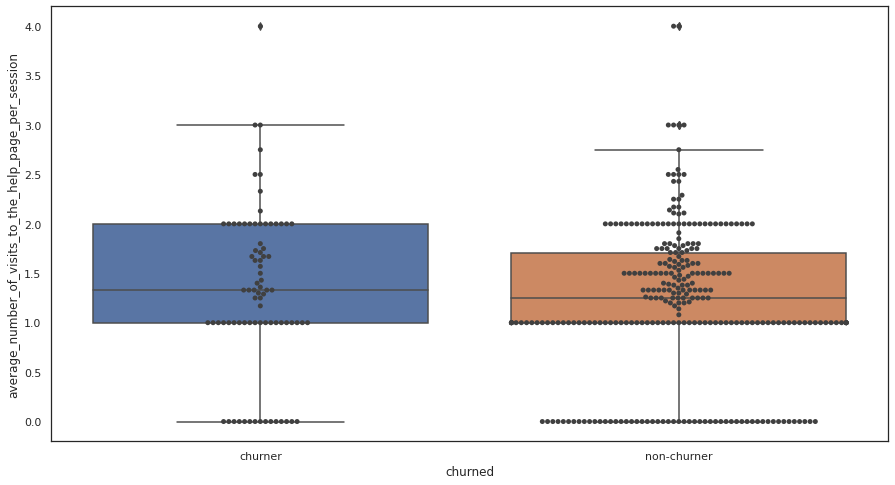

In [225]:
avg_num_of_visits_to_the_help_page_per_session = comparison_summary("Help", "average_number_of_visits_to_the_help_page_per_session", train_data, train_users, True, "number of visits to the Help page per session")

<b>Average number of visits to the settings page per session : Settings</b>

<b>Nearly identical, however non-churners frequent the Setting page slightly more per session </b>

+------+--------------------------------------------------+
|userId|avg_num_of_visits_to_the_settings_page_per_session|
+------+--------------------------------------------------+
|   296|                                               1.0|
|   125|                                               1.5|
|   124|                                              2.14|
|     7|                                               1.0|
|200037|                                               1.0|
|   169|                                               1.0|
|   205|                                               1.5|
|   232|                                              1.63|
|   234|                                              1.89|
|   282|                                              2.13|
+------+--------------------------------------------------+
only showing top 10 rows



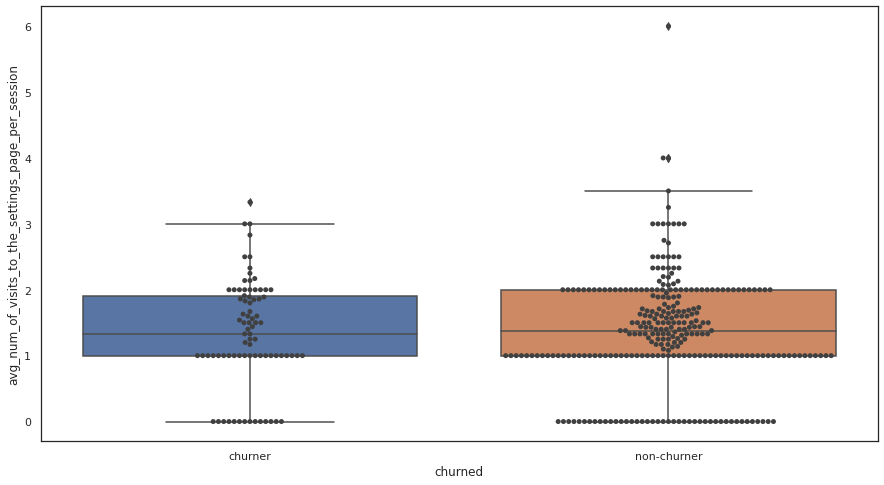

In [226]:
avg_num_of_visits_to_the_settings_page_per_session = comparison_summary("Settings", "avg_num_of_visits_to_the_settings_page_per_session", train_data, train_users, True, "number of visits to the Settings page")

<b>Average number of times settings changed per session : Save Settings</b>

<b>No difference really</b>

+------+---------------------------------------------+
|userId|avg_num_of_times_settings_changed_per_session|
+------+---------------------------------------------+
|   124|                                          1.5|
|     7|                                          1.0|
|   169|                                          1.0|
|   205|                                          1.0|
|   232|                                          1.0|
|   234|                                          1.0|
|   282|                                          1.0|
|   155|                                          1.0|
|200043|                                          2.0|
|   154|                                          1.0|
+------+---------------------------------------------+
only showing top 10 rows



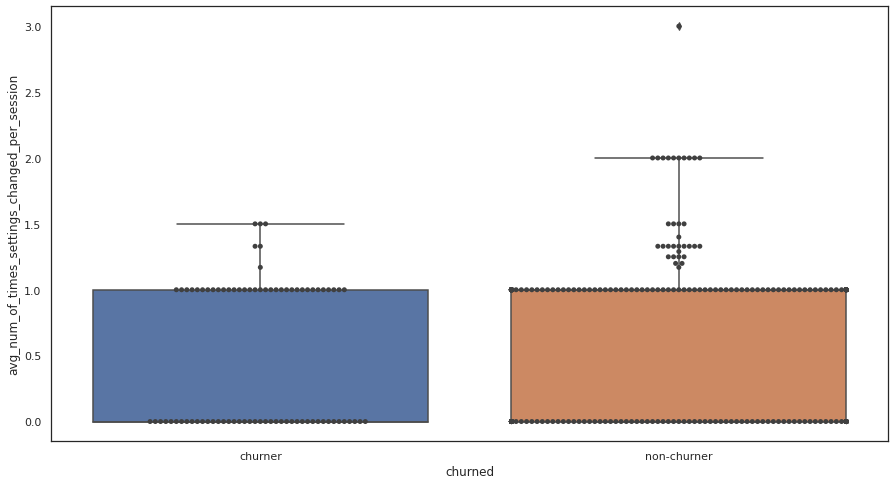

In [227]:
avg_num_of_times_the_settings_changed_per_session = comparison_summary("Save Settings", "avg_num_of_times_settings_changed_per_session", train_data, train_users, True, "number of times settings was changed")

<b>Average number of thumbs up per session : Thumbs Up</b>

<b>Non-churners use the thumbs up more frequently per session</b>

+------+--------------------------------+
|userId|avg_num_of_thumbs_up_per_session|
+------+--------------------------------+
|100010|                             2.0|
|   296|                            2.67|
|   125|                             1.5|
|   124|                             6.8|
|     7|                            1.71|
|200037|                            1.25|
|   169|                             1.2|
|   205|                            12.5|
|   272|                             3.5|
|   232|                            5.11|
+------+--------------------------------+
only showing top 10 rows



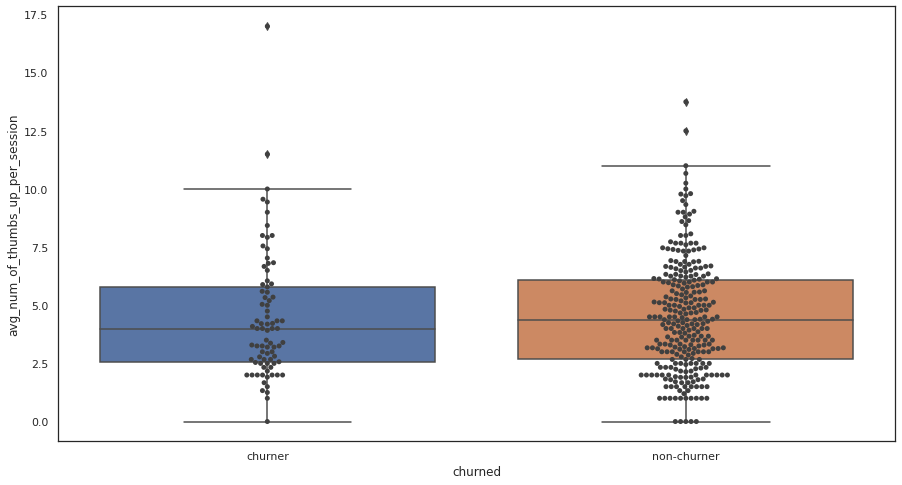

In [228]:
avg_num_of_thumbs_up_per_session = comparison_summary("Thumbs Up", "avg_num_of_thumbs_up_per_session", train_data, train_users, True, "number of thumbs up")

<b>Average number of thumbs down per session : Thumbs Down</b>

<b>The churners hit the thumbs down button more frequently per session</b>

+------+----------------------------------+
|userId|avg_num_of_thumbs_down_per_session|
+------+----------------------------------+
|100010|                               1.5|
|   125|                               1.0|
|   124|                              2.14|
|     7|                               1.0|
|200037|                               1.5|
|   205|                               2.5|
|   272|                               2.0|
|   232|                               1.7|
|   234|                               2.2|
|   282|                              1.93|
+------+----------------------------------+
only showing top 10 rows



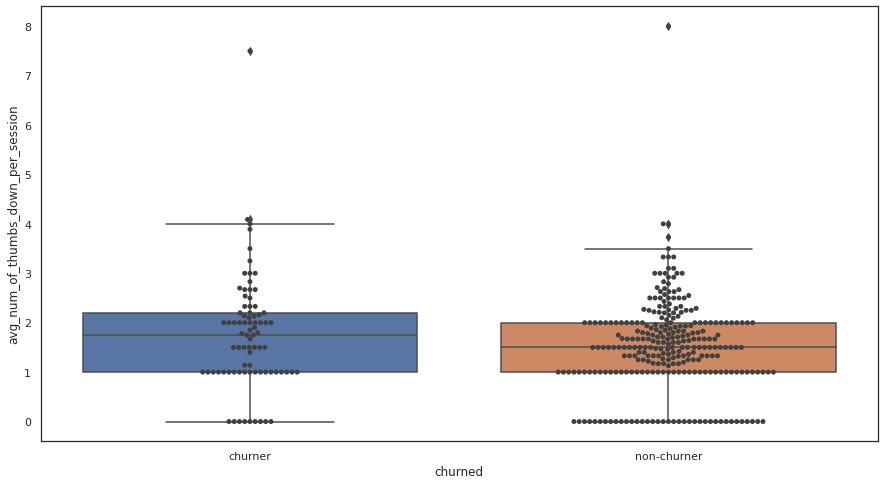

In [229]:
avg_num_of_thumbs_down_per_session = comparison_summary("Thumbs Down", "avg_num_of_thumbs_down_per_session", train_data, train_users, True, "number of thumbs down")

<b>Average number of add to playlists per session : Add to Playlist</b>

<b>The non-churners add songs to their playlist more frequently per session </b>

+------+--------------------------------------+
|userId|avg_num_of_add_to_playlist_per_session|
+------+--------------------------------------+
|100010|                                   1.0|
|   296|                                   1.5|
|   125|                                   1.0|
|   124|                                  4.09|
|     7|                                   2.0|
|200037|                                   2.0|
|   205|                                   5.0|
|   272|                                   1.5|
|   232|                                  4.36|
|   234|                                  4.25|
+------+--------------------------------------+
only showing top 10 rows



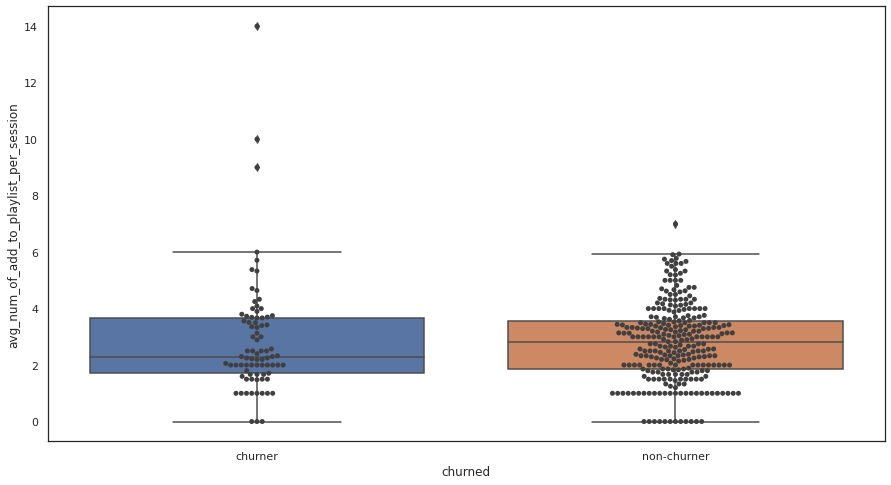

In [230]:
avg_num_of_add_to_playlist_per_session = comparison_summary("Add to Playlist", "avg_num_of_add_to_playlist_per_session", train_data, train_users, True, "number of add to playlist")

<b>Average number of AddFriends per session : Add Friend</b>

<b>The non-churners add friends more frequently per session</b>

+------+---------------------------------+
|userId|avg_num_of_addfriends_per_session|
+------+---------------------------------+
|100010|                              1.5|
|   296|                              2.0|
|   125|                              1.5|
|   124|                              2.6|
|     7|                             2.67|
|200037|                              1.0|
|   169|                              6.0|
|   205|                             5.25|
|   232|                              4.3|
|   234|                             2.13|
+------+---------------------------------+
only showing top 10 rows



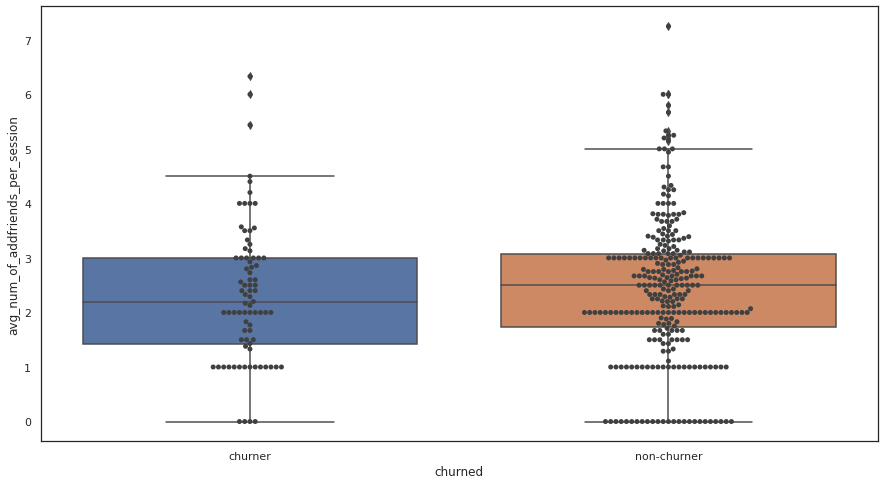

In [231]:
avg_num_of_addfriends_per_session = comparison_summary("Add Friend", "avg_num_of_addfriends_per_session", train_data, train_users, True, "number of Add Friend")

<b>Average number of Errors faced per session : Error</b>

<b>Nothing noteworthy here. Both seem to face errors</b>

+------+--------------------------------+
|userId|avg_number_of_errors_per_session|
+------+--------------------------------+
|   205|                             1.0|
|   232|                             1.0|
|   234|                             1.0|
|   282|                             1.0|
|   155|                             1.0|
|   101|                             1.2|
|   279|                             1.0|
|300017|                             1.0|
|    29|                            1.25|
|    69|                             1.0|
+------+--------------------------------+
only showing top 10 rows



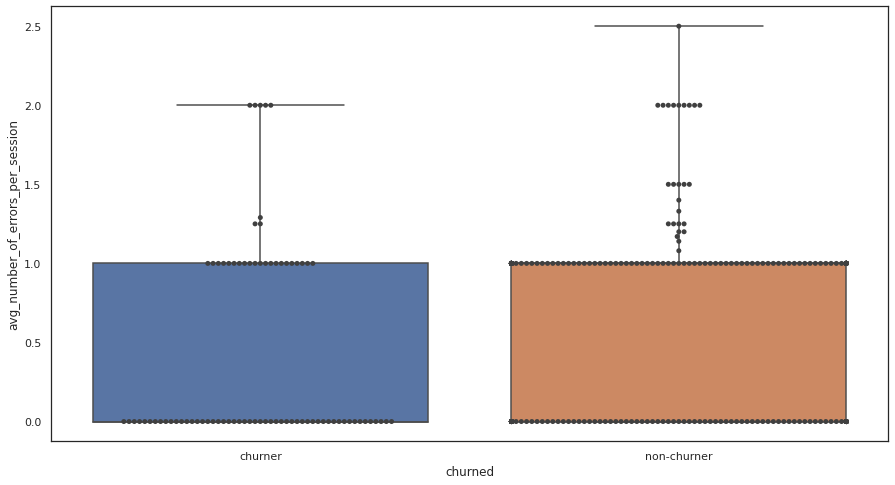

In [232]:
avg_number_of_errors_per_session = comparison_summary("Error", "avg_number_of_errors_per_session", train_data, train_users, True, "number of Errors")

<b>Average number of visits to the upgrade page : Upgrade</b>

<b>Nothing that pops out here</b>

+------+---------------------------------+
|userId|avg_num_of_visits_to_upgrade_page|
+------+---------------------------------+
|100010|                              2.0|
|   296|                              1.0|
|     7|                              1.5|
|   169|                              2.0|
|   272|                              1.0|
|   232|                              1.5|
|   234|                              1.0|
|   282|                             1.25|
|200043|                              2.0|
|   132|                              2.0|
+------+---------------------------------+
only showing top 10 rows



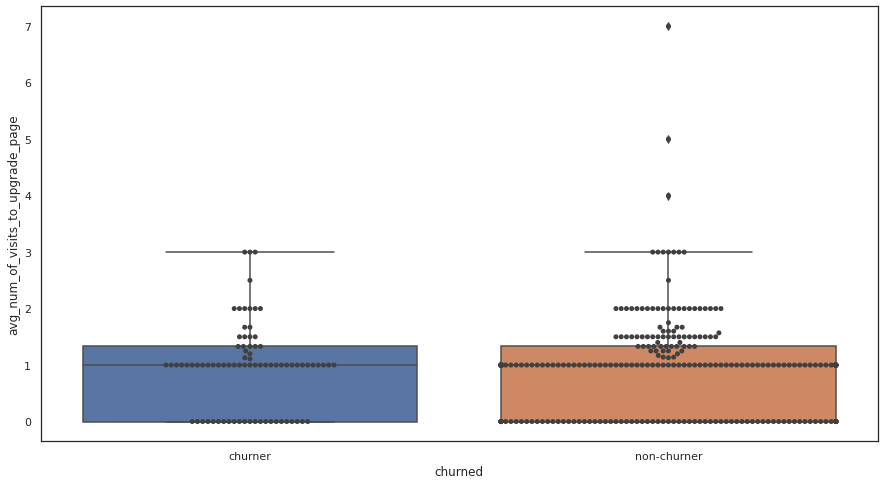

In [233]:
avg_num_of_visits_to_upgrade_page = comparison_summary("Upgrade", "avg_num_of_visits_to_upgrade_page", train_data, train_users, True, "number of Upgrade")

<b>Average number of visits to the downgrade page : Downgrade</b>

<b>Here, it looks like churners are more likely to visits the downgrade page</b>

+------+--------------------------------------+
|userId|avg_number_of_visits_to_downgrade_page|
+------+--------------------------------------+
|   296|                                   1.0|
|   124|                                  2.33|
|   205|                                  3.33|
|   232|                                   2.8|
|   234|                                   2.0|
|   282|                                  2.11|
|    54|                                  1.25|
|   155|                                   1.0|
|200043|                                   1.0|
|100014|                                   3.0|
+------+--------------------------------------+
only showing top 10 rows



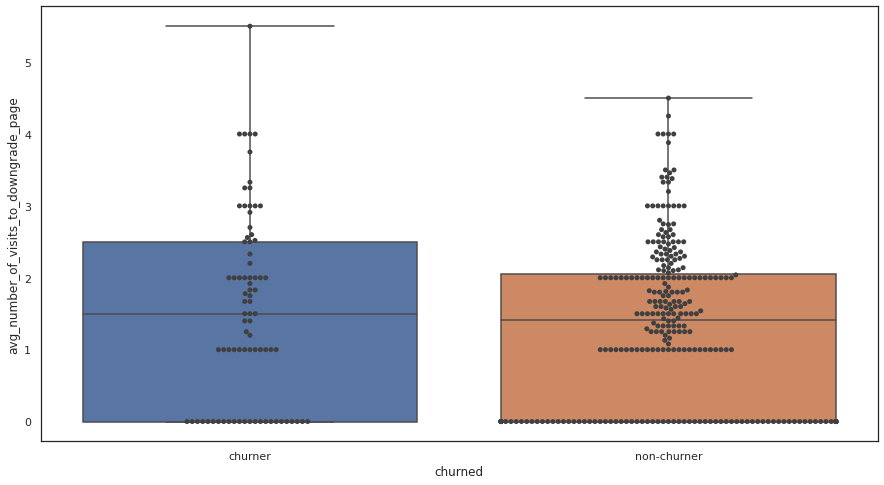

In [234]:
avg_number_of_visits_to_downgrade_page = comparison_summary("Downgrade", "avg_number_of_visits_to_downgrade_page", train_data, train_users, True, "number of downgrades")

<b>Number of downgrades : Submit Downgrade</b>

<b>No visible difference here</b>

+------+---------------------------+
|userId|num_of_downgrades_submitted|
+------+---------------------------+
|   232|                          1|
|   279|                          1|
|100021|                          2|
|    29|                          1|
|    69|                          1|
|    42|                          1|
|300035|                          1|
|   139|                          1|
|   250|                          2|
|100029|                          1|
|   160|                          1|
|   203|                          1|
|   251|                          1|
|    52|                          1|
|300008|                          1|
|   195|                          1|
|100025|                          1|
|100006|                          1|
|    18|                          1|
|   174|                          1|
+------+---------------------------+
only showing top 20 rows



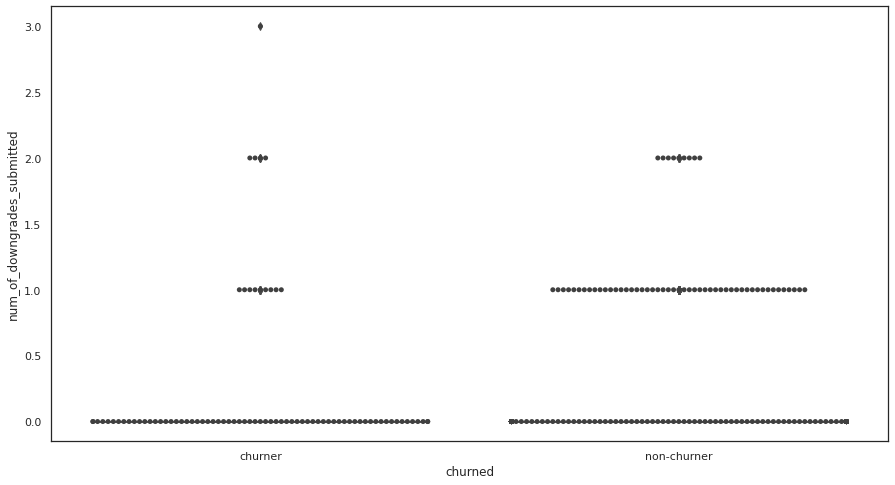

In [235]:
number_of_downgrade_submits_per_user = comparison_summary_for_user("Submit Downgrade", "num_of_downgrades_submitted", train_data, train_users, True, "number of downgrades submitted")

<b>Number of upgrades : Submit Upgrade</b>

<b>Again, no real difference</b>

+------+-------------------------+
|userId|num_of_upgrades_submitted|
+------+-------------------------+
|   296|                        1|
|   232|                        2|
|   234|                        1|
|   282|                        1|
|200043|                        1|
|   132|                        1|
|   101|                        1|
|    11|                        1|
|   279|                        1|
|100021|                        3|
|    29|                        2|
|    69|                        1|
|    42|                        2|
|300035|                        2|
|   113|                        1|
|    30|                        1|
|    34|                        1|
|   162|                        1|
|   139|                        1|
|   146|                        1|
+------+-------------------------+
only showing top 20 rows



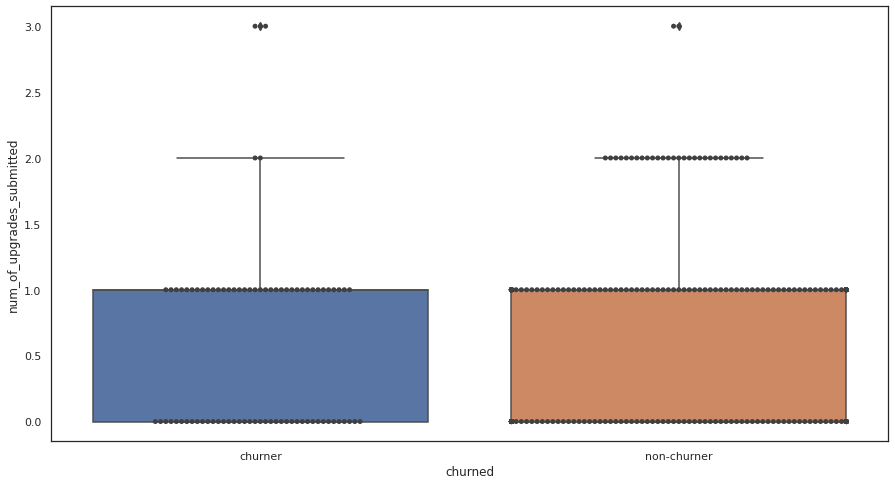

In [236]:
number_of_upgrade_submits_per_user = comparison_summary_for_user("Submit Upgrade", "num_of_upgrades_submitted", train_data, train_users, True, "number of upgrades submitted")

<b>Average number of different artists listened per session</b>

<b>The non-churners listen to more number of artist per session</b>

+------+------------------------------+
|userId|avg_num_of_artists_per_session|
+------+------------------------------+
|100010|                          49.0|
|   296|                          23.0|
|   125|                         21.33|
|   124|                         100.0|
|     7|                          31.2|
|200037|                          18.0|
|   169|                         14.88|
|   205|                         190.4|
|   272|                          48.5|
|   232|                         77.35|
+------+------------------------------+
only showing top 10 rows



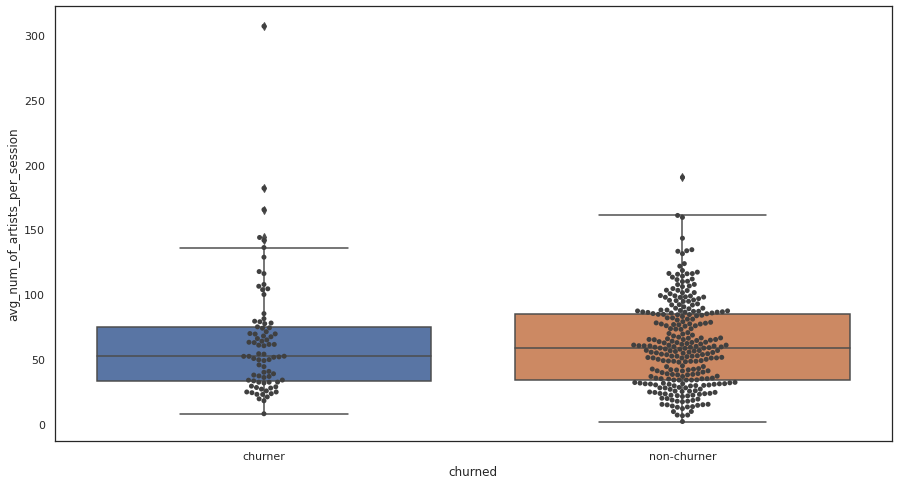

In [237]:
avg_num_of_artists_per_session = get_avg_number_of_artists_listened_per_session_per_user(train_data, train_users, plot=True, plot_title="Number of artists per session")

<b>Number of different levels the user switched</b>

<b>Again, no visible difference</b>

+------+-----------------------------+
|userId|num_times_user_changed_levels|
+------+-----------------------------+
|100010|                            0|
|   296|                            1|
|   125|                            0|
|   124|                            0|
|     7|                            0|
|200037|                            0|
|   169|                            0|
|   205|                            0|
|   272|                            0|
|   232|                            3|
+------+-----------------------------+
only showing top 10 rows



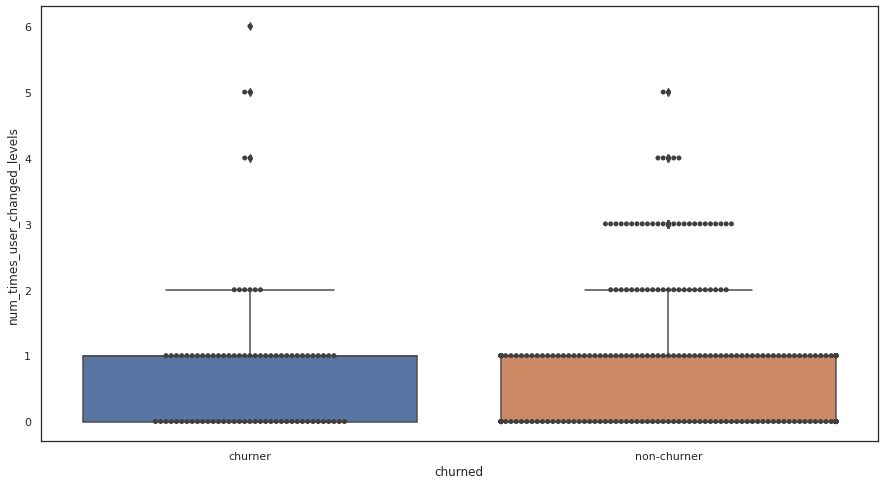

In [238]:
num_of_times_user_changed_levels = get_number_of_times_each_user_changed_levels(train_data, train_users, plot=True)

<b>Using gender as a feature</b>

In [239]:
users_gender = get_user_gender(train_data)
users_gender.show(10)

+------+------+
|userId|gender|
+------+------+
|100010|     F|
|   296|     F|
|   125|     M|
|   124|     F|
|     7|     M|
|200037|     M|
|   169|     M|
|   205|     F|
|   272|     F|
|   232|     F|
+------+------+
only showing top 10 rows



Having visually compared several features, some of which showed difference of behavior of churner and non-churners and some didn't. We will in this project retain all these features and use techniques like regularization to reduce the affect of insignificant features.

## Using the features, prepare a dataset that can be fed to a machine learning model

In [16]:
final_train_df = aggregate_features(train_data, train_users, False)

In [17]:
final_train_df.show(5)

+------+-------+--------------------------------------+---------------------------------+------------------------------+------------------------------+----------------------------+----------------------------------+--------------------------------+---------------------------------------------+------------------------------------------------------+-----------------------------------------------------+-------------------------------------+--------------------------------------------------+---------------------------------+--------------------------------+--------------------------------------+-----------------------------+---------------------------+-------------------------+------+
|userId|churned|avg_num_of_add_to_playlist_per_session|avg_num_of_addfriends_per_session|avg_num_of_adverts_per_session|avg_num_of_artists_per_session|avg_num_of_songs_per_session|avg_num_of_thumbs_down_per_session|avg_num_of_thumbs_up_per_session|avg_num_of_times_settings_changed_per_session|average_number_o

In [18]:
final_test_df = aggregate_features(test_data, test_users, False)

In [19]:
final_test_df.show(5)

+------+-------+--------------------------------------+---------------------------------+------------------------------+------------------------------+----------------------------+----------------------------------+--------------------------------+---------------------------------------------+------------------------------------------------------+-----------------------------------------------------+-------------------------------------+--------------------------------------------------+---------------------------------+--------------------------------+--------------------------------------+-----------------------------+---------------------------+-------------------------+------+
|userId|churned|avg_num_of_add_to_playlist_per_session|avg_num_of_addfriends_per_session|avg_num_of_adverts_per_session|avg_num_of_artists_per_session|avg_num_of_songs_per_session|avg_num_of_thumbs_down_per_session|avg_num_of_thumbs_up_per_session|avg_num_of_times_settings_changed_per_session|average_number_o

<b>Saving the created feature matrix as parquet file. This way, we can directly use these files for modelling.</b>

In [20]:
train_file_path = "train_data.parquet"
test_file_path = "test_data.parquet"
final_train_df.write.parquet(train_file_path)
final_test_df.write.parquet(test_file_path)

## Conclusion of Part 1:

- We have used pyspark to analyse a small subset of a full dataset. This pyspark code can directly be run on the full dataset using a spark cluster.
- We identified null and missing values and cleaned the dataset as to only retain data useful for our task of identifying users that could churn.
- We created features that can be used to identify users as churners and non-churners.
- We created a feature matrix and stored it and now it can used for modelling. We will do that in Part 2.